# Fellowship.ai One-Shot Learning Challenge (Revision)

For the fellowship challenge, I chose the one-shot learning problem. My reasoning for choosing this challenge is that I would like to get more involved in using AI for image processing and computer vision. This challenge gave me the experience of working with large image datasets.

### Deep Learning: Siamese/Relation Networks

The most effective and conceptually simple methods for one-shot learning seem to involve using a "siamese" network architecture. The idea is to feed one training image and one test image through a convolutional network with identical parameters. Then the results from both images are fed into another neural network to teach the model to "compare" images.

The original idea applied to one-shot learning was put forth in this paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

For my project, I used a similar strategy to this paper because it has a more compact structure than the original siamese network: http://openaccess.thecvf.com/content_cvpr_2018/papers_backup/Sung_Learning_to_Compare_CVPR_2018_paper.pdf

To create my deep learning model, I used several strategies from the two papers including:

-Resizing the images (I chose 26x26 which is approx. 1/4 size)

-Distorting the images for training (I used a random affine transform to slightly perturb each image)

-Batching several classes at once for each training iteration/episode

I also chose to invert the black/white of the images because it works better with the pytorch affine transform function.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

from PIL import Image, ImageOps

from torch.autograd import Variable

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler

from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

import os
import math
import random

In [67]:
PATH = './SN_Training/siamese_jupyter'
TEST_PATH = './SN_Training/siamese_jupyter'

### Hyperparameters:

Most of the hyperparameters of the model are the same as the Relation Network paper, however there are a few key differences:

-Because sampling 20 classes x 10 examples per class was not feasible with the amount of GPU memory/speed available to me, I decided against it in favor of only sampling 10 classes with 9 examples per class. This also balanced the matching examples with a single mismatched example from each class (9 vs 9) which prevented the network from overfitting to the distribution of classes. A relatively low loss (95% "correct") could be obtained by guessing no relation for all classes.

-Images were resized to 26x26 and the network architecture was slightly modified to ensure weights fit all sizes.

-Trained for 100000 "episodes" and stepped the learning rate down every 10000 episodes.

In [12]:
###############################################
#Hyperparameters
###############################################
IMG_SIZE = 26
HIDDEN_LAYER_SIZE = 8
FC_SIZE = 64
LEARNING_RATE = 0.001
NUM_EX = 9
NUM_CL = 10
EPISODES = 100000
LR_STEP = 10000

#### Notable Helper Functions: 
I used the bitflip function to change the images so that the character is represented by 1 (white) instead of 0 (black).
The "make target" function is to return 0 for a mismatched pair and 1 for a matching pair.

In [13]:
###############################################
#Helper Functions
###############################################

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def bitflip(x):
    x = torch.mul(x, -1) + 1
    return x

def make_optimizer(NN_Name, LearningRate):
    #input a string representing the name of network
    #learning rate should probably be 0.001 or less
    optimizer = optim.Adam(NN_Name.parameters(), lr = LearningRate)
    return optimizer

def make_target(cl1,cl2):
    target = cl1==cl2
    return target

def init_weights(m):
    # use by doing $ModuleName$.$layer$.apply(init_weights)
    if type(m) == nn.Conv2d:
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif type(m) == nn.BatchNorm1d:
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif type(m) == nn.Linear:
        n = m.weight.size(1)
        m.weight.data.normal_(0, math.sqrt(2. / n))
        m.bias.data = torch.ones(m.bias.data.size())

#### Image Transform:
Pytorch transform function for each image is composed of:
1. grayscale (convert to single channel image)
2. conversion to numbers followed by the bitflip function
3. conversion back to PIL image and randomly affine transformed
4. slight crop to 104x104 and resized by 1/4 to 26x26
5. finally converted back to numbers and normalized by the mean and stdev of all image pixel values

The vis_ transforms are for displaying the images only.

In [14]:
###############################################
#Build transforms
###############################################

# found across the entire dataset pixel values
avg_flip = 0.924562 #original black char/white bg
avg = 0.075438 #converted to white char/black bg
stdev = 0.264097

transform = T.Compose([
                T.Grayscale(),
                T.ToTensor(),
                T.Lambda(lambda x: bitflip(x)),
                T.ToPILImage(),
                T.RandomAffine(15, translate=None, scale=(0.8,1.2), shear=17),
                T.CenterCrop(104),
                T.Resize((IMG_SIZE,IMG_SIZE),interpolation=1),
                T.ToTensor(),
                T.Normalize([avg], [stdev])
            ])

transform_no_aff = T.Compose([
                T.Grayscale(),
                T.ToTensor(),
                T.Lambda(lambda x: bitflip(x)),
                T.ToPILImage(),
                T.CenterCrop(104),
                T.Resize((IMG_SIZE,IMG_SIZE),interpolation=1),
                T.ToTensor(),
                T.Normalize([avg], [stdev])
            ])

vis_transform = T.Compose([
                T.Grayscale(),
                T.ToTensor(),
                T.Lambda(lambda x: bitflip(x)),
                T.ToPILImage(),
                T.RandomAffine(15, translate=None, scale=(0.8,1.2), shear=17),
                T.CenterCrop(104),
                T.Resize((IMG_SIZE,IMG_SIZE),interpolation=1),
                T.ToTensor()        
            ])

vis_transform_no_aff = T.Compose([
                T.Grayscale(),
                T.ToTensor(),
                T.Lambda(lambda x: bitflip(x)),
                T.ToPILImage(),
                T.CenterCrop(104),
                T.Resize((IMG_SIZE,IMG_SIZE),interpolation=1),
                T.ToTensor()
            ])

I built a custom pytorch sampler to take a certain number of classes per episode and number of examples per class. This can be modified through the hyperparameters NUM_CL and NUM_EX respectively.

In [15]:
###############################################
#Build Custom Sampler Classes
###############################################

class SampleSampler(Sampler):
    '''Samples 'num_inst' examples each from 'num_cl' groups. 
    for one shot learning, num_inst is 1 for sample group.
    'total_inst' per class, 'total_cl' classes'''

    def __init__(self, num_cl=20, total_cl=963, num_inst=1, total_inst=20, shuffle=True):
        self.num_cl = num_cl
        self.total_cl = total_cl
        self.num_inst = num_inst
        self.total_inst = total_inst
        self.cl_list = list(np.random.choice(total_cl, num_cl, replace=False))
        self.ex_list = list(np.random.randint(total_inst, size=num_inst*20))
        self.shuffle = shuffle
        batch = []
        for i, cl in enumerate(self.cl_list):
            batch = batch + [20*cl+self.ex_list[i]]
        mix = batch[:]

        if self.shuffle:
            np.random.shuffle(mix)
        self.batch = batch
        self.mix = mix      

    def __iter__(self):
        # return a single list of indices, assuming that items are grouped 20 per class
        if self.shuffle:
            return iter(self.mix)
        else:
            return iter(self.batch)

    # the following functions help you retrieve instances
    # index of original dataset will be 20*class + example
    def get_classes(self):
        return self.cl_list

    def get_examples(self):
        return self.ex_list

    def get_batch_idc(self):
        return self.batch

    def __len__(self):
        return len(self.batch)

class QuerySampler(Sampler):
    '''Samples queries based on class list and example list'''

    def __init__(self, cl_list, ex_list, num_inst=19, shuffle=False):
        self.cl_list = cl_list
        self.ex_list = ex_list
        self.num_inst = num_inst
        self.shuffle = shuffle
        batch = []
        for i, cl in enumerate(self.cl_list):
            remaining_ex = list(range(20))
            remaining_ex.remove(self.ex_list[i])
            queries = random.sample(remaining_ex, self.num_inst)
            for query in queries:
                batch = batch + [20*cl+query]

        if self.shuffle:
            np.random.shuffle(batch)
        
        self.batch = batch

    def __iter__(self):
        # return a single list of indices, assuming that items are grouped 20 per class
        return iter(self.batch)

    # the following functions help you retrieve instances
    # index of original dataset will be 20*class + example
    def get_classes(self):
        return self.cl_list

    def get_examples(self):
        return self.ex_list

    def get_batch_idc(self):
        return self.batch

    def __len__(self):
        return len(self.batch)

In [16]:
###############################################
#CUDA stuff
###############################################

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


### Network Architecture: 

This is the main network which consists of an identical twin network with 4 convolutional layers, each with 64 3x3 filters, batch norm, ReLU, and MaxPool.

The 2 outputs of the twin network are concatenated and then fed through a relational network which consists of two more convolutional layers, with the last layer output size 1. Because batchnorm won't work on a 1D feature, I used SELU to try and mimic the effect of normalization. After that the 1D channels are flattened and fed through a fully connected SELU and finally a fully connected sigmoid to give a "matching probability." The output of the first FC layer is size 8 as in the paper.

In [17]:
###############################################
#Build Siamese Networks
###############################################

class SiameseNetwork(nn.Module):
    def __init__(self, in_channel=1, channel_num=64, FC_num=64, hidden_num=8, output_size=1):
        super().__init__()

        self.layer1 = nn.Sequential(
                        nn.Conv2d(in_channel,channel_num,kernel_size=3,padding=0),
                        nn.BatchNorm2d(channel_num, momentum=0.01, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(channel_num,channel_num,kernel_size=3,padding=1),
                        nn.BatchNorm2d(channel_num, momentum=0.01, affine=True),
                        nn.ReLU(),                        
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(channel_num,channel_num,kernel_size=3,padding=1),
                        nn.BatchNorm2d(channel_num, momentum=0.01, affine=True),
                        nn.ReLU())
        self.layer4 = nn.Sequential(
                        nn.Conv2d(channel_num,channel_num,kernel_size=3,padding=1),
                        nn.BatchNorm2d(channel_num, momentum=0.01, affine=True),
                        nn.ReLU())

        # output is 6x6x64 after conv section
        self.comp1 = nn.Sequential(
                        nn.Conv2d(channel_num*2,channel_num,kernel_size=3,padding=1),
                        nn.BatchNorm2d(channel_num, momentum=0.01, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        # this is technically a fully connected layer
        self.comp2 = nn.Sequential(
                        nn.Conv2d(channel_num,channel_num,kernel_size=3,padding=0),
                        nn.SELU())
        
        # input is 64 to FC layer 1
        self.fc1 = nn.Sequential(
                    nn.Linear(FC_num,hidden_num),
                    nn.SELU())
        self.fc2 = nn.Sequential(
                    nn.Linear(hidden_num,output_size),
                    nn.Sigmoid())

    def forward_once(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out
    
    def relate(self, x):
        out = self.comp1(x)
        out = self.comp2(out)
        out = flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

    def forward(self,x1,x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        out_cat = torch.cat((out1,out2),1)
        out3 = self.relate(out_cat)
        return out3

I used the ImageFolder pytorch class after reorganizing the files and applied the appropriate transforms.

In [18]:
###############################################
#Build Dataset
###############################################

#training set has 963 classes 
#test set has has 659 classes
#all images were dumped into two folders for training and testing
omni_train = dset.ImageFolder(root='./training_images/', transform=transform)
omni_train_no_aff = dset.ImageFolder(root='./training_images/', transform=transform_no_aff)
omni_test  = dset.ImageFolder(root='./testing_images/', transform=transform_no_aff)
omni_vis_train = dset.ImageFolder(root='./training_images/', transform=vis_transform)
omni_vis_train_no_aff = dset.ImageFolder(root='./training_images/', transform=vis_transform_no_aff)


#### Testing:
To test the model, I randomly select 20 classes from the testing set and choose 2 examples at random; one for "training sample" and one for "test query." Each query is paired with a training sample and a relation score probability is output. The class with the maximum relation score is chosen as the hypothesis. Accuracy is (number correct)/20 for each episode. I thoroughly test the model by going through 1000 episodes.

In [19]:
###############################################
#Function for testing the model
###############################################

def check_accuracy(sample_loader, query_loader, model):
    num_correct = 0
    num_queries = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        model.to(device=device,dtype=dtype)
        for i, (query, query_label) in enumerate(query_loader):
            # for each of 20 queries
            num_queries += 1
            max_score = 0
            truth = None
            for j, (sample, sample_label) in enumerate(sample_loader):
                # check against the 20 one-shot training samples
                sample = sample.to(device=device,dtype=dtype)
                query = query.to(device=device,dtype=dtype)
                score = model(sample, query)
                if query_label==sample_label:
                    truth = j
                if score > max_score:
                    max_score = score
                    hypothesis = j

            if hypothesis == truth:
                num_correct += 1
        acc = num_correct/num_queries
        print('Got %d / %d correct (%.2f)' % (num_correct, num_queries, 100 * acc))
        acc_list = [acc]
        return acc_list

#### Training:
To train the model, I sample some number of classes and examples for each class. Each class pairs up with NUM_EX of its own class and once for each other class. Generally I choose NUM_EX to be NUM_CL - 1 for an equal number of matches and mismatches. I obtained the best performance thus far with 10 classes and 9 examples. Higher numbers were too resource intensive to be able to test, and lower numbers gave slightly less accuracy.

In [20]:
###############################################
#Function to Train the model
###############################################

def train_SN(model, optimizer, scheduler, episodes=1):
    """Train using siamese network"""
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for episode in range(episodes):
        scheduler.step(episode)
        model.train() # set to train mode

        # make the samplers 
        # make 2 samplers, one for the "training sample set" of a one-shot classifier
        # other sampler is for the "test query set" which provides many comparisons
        train_sample_sampler = SampleSampler(num_cl=NUM_CL)
        sampled_classes = train_sample_sampler.cl_list
        sampled_examples = train_sample_sampler.ex_list
        train_query_sampler = QuerySampler(sampled_classes, sampled_examples, num_inst=NUM_EX)

        # make the dataloaders
        s_batch_num = 1 # one shot "training" each
        q_batch_num = NUM_EX # pair up number of examples per class in a batch (default 19)
        train_sample_loader = DataLoader(omni_train, batch_size=s_batch_num, sampler=train_sample_sampler)
        train_query_loader = DataLoader(omni_train, batch_size=q_batch_num, sampler=train_query_sampler)
        
        # start training
        scores = torch.zeros(NUM_CL,(NUM_EX+NUM_CL-1)).to(device=device, dtype=dtype)
        targets = torch.zeros(NUM_CL,(NUM_EX+NUM_CL-1)).to(device=device, dtype=dtype)
        sample_count = 0
        for i, (sample, sample_label) in enumerate(train_sample_loader):
            sample_count += 1
            idx = 0
            for j, (batch, batch_labels) in enumerate(train_query_loader):
                if sample_label != batch_labels[0]:
                    k = np.random.randint(NUM_EX)
                    query = batch[k,:,:,:].to(device=device, dtype=dtype)
                    query = query.view(1,1,IMG_SIZE,IMG_SIZE)
                    sample = sample.to(device=device, dtype=dtype)
                    targets[i,idx] = make_target(sample_label, batch_labels[0])
                    scores[i,idx] = model(sample,query)
                    idx += 1
                    
                elif sample_label == batch_labels[0]:
                    for k in range(NUM_EX):
                        query = batch[k,:,:,:].to(device=device, dtype=dtype)
                        query = query.view(1,1,IMG_SIZE,IMG_SIZE)
                        sample = sample.to(device=device, dtype=dtype)
                        targets[i,idx] = make_target(sample_label, batch_labels[0])
                        scores[i,idx] = model(sample,query)
                        idx += 1
            
        targets = targets.view(-1)
        scores = scores.view(-1)
        
        # train and update model
        optimizer.zero_grad()
        #loss = F.binary_cross_entropy(scores, targets)
        loss = F.mse_loss(scores, targets)
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()

        # episodic updates
        if (episode+1)%10 == 0:
            print("episode:",episode+1,"loss",loss.data)

        if (episode+1)%100 == 0:
            ''' Test the model '''
            # make the samplers 
            test_sample_sampler = SampleSampler(total_cl=659)
            sampled_classes = test_sample_sampler.cl_list
            sampled_examples = test_sample_sampler.ex_list
            test_query_sampler = QuerySampler(sampled_classes, sampled_examples, num_inst=1)

            # make the dataloaders
            s_batch_num = 1 # one shot each
            q_batch_num = 1 # one test each
            test_sample_loader = DataLoader(omni_test, batch_size=s_batch_num, sampler=test_sample_sampler)
            test_query_loader = DataLoader(omni_test, batch_size=q_batch_num, sampler=test_query_sampler)
            check_accuracy(test_sample_loader, test_query_loader, model)

        if (episode+1)%1000 == 0:
            """ Save as a draft model """
            torch.save(model.state_dict(), PATH)

In [21]:
###############################################
#Train the net
###############################################
def TrainTheModel():
    snet = SiameseNetwork(FC_num=FC_SIZE,hidden_num=HIDDEN_LAYER_SIZE)
    snet.layer1.apply(init_weights)
    snet.layer2.apply(init_weights)
    snet.layer3.apply(init_weights)
    snet.layer4.apply(init_weights)
    snet.comp1.apply(init_weights)
    snet.comp2.apply(init_weights)
    snet.fc1.apply(init_weights)
    snet.fc2.apply(init_weights)

    snet_optim = make_optimizer(snet,LEARNING_RATE)
    snet_scheduler = StepLR(snet_optim,step_size=LR_STEP,gamma=0.5)
    print("Begin Training...")
    train_SN(snet, snet_optim, snet_scheduler, episodes = EPISODES)


In [22]:
###############################################
#Test after saving a model
###############################################
def TestTheModel(model):
    ''' Test the model '''
    # make the samplers 
    test_sample_sampler = SampleSampler(total_cl=659)
    sampled_classes = test_sample_sampler.cl_list
    sampled_examples = test_sample_sampler.ex_list
    test_query_sampler = QuerySampler(sampled_classes, sampled_examples, num_inst=1)

    # make the dataloaders
    s_batch_num = 1 # one shot each
    q_batch_num = 1 # one test each
    test_sample_loader = DataLoader(omni_test, batch_size=s_batch_num, sampler=test_sample_sampler)
    test_query_loader = DataLoader(omni_test, batch_size=q_batch_num, sampler=test_query_sampler)
    return check_accuracy(test_sample_loader, test_query_loader, model)

### Main Program:
Running the test program results in around 80% accuracy.
Running the training mode will output the loss for each episode, and save a model every 1000 episodes for training later.

In [72]:
###############################################
#Main Program
###############################################
if __name__ == '__main__':
    program_mode = None
    while(program_mode != '1' and program_mode != '2'):
        program_mode = input('Press 1 for Train and 2 for Test.\n')
        if program_mode == '1':
            TrainTheModel()
        elif program_mode == '2':
            model = SiameseNetwork(FC_num=FC_SIZE,hidden_num=HIDDEN_LAYER_SIZE)
            model.load_state_dict(torch.load(TEST_PATH))
            scores = []
            for i in range(20):
                scores += TestTheModel(model)
            avg_score = 100*np.mean(scores)
            std_score = 100*np.std(scores, ddof=1)
            print('Mean (%.2f) StDev (%.2f)' % (avg_score, std_score))
            np.save('scores_jupyter',scores)
        else:
            print('Sorry, try again.')

Press 1 for Train and 2 for Test.
2
Got 18 / 20 correct (90.00)
Got 17 / 20 correct (85.00)
Got 19 / 20 correct (95.00)
Got 17 / 20 correct (85.00)
Got 13 / 20 correct (65.00)
Got 13 / 20 correct (65.00)
Got 13 / 20 correct (65.00)
Got 18 / 20 correct (90.00)
Got 17 / 20 correct (85.00)
Got 18 / 20 correct (90.00)
Got 16 / 20 correct (80.00)
Got 15 / 20 correct (75.00)
Got 15 / 20 correct (75.00)
Got 19 / 20 correct (95.00)
Got 18 / 20 correct (90.00)
Got 18 / 20 correct (90.00)
Got 16 / 20 correct (80.00)
Got 14 / 20 correct (70.00)
Got 19 / 20 correct (95.00)
Got 16 / 20 correct (80.00)
Mean (82.25) StDev (10.19)


## Visualizations and Results:

The following code blocks will load a random image from the training set and perform an affine transform on it. This allows us to see how the network might be able to recognize the same image despite some distortions.

Affine parameters are randomly selected from:
[-15, +15] degree rotation;
[0.8, 1.2] scale multiplier;
[-17, +17] degrees of shear.

These are similar to the affine transform from the Siamese Network paper. Shear degrees were calculated through arctan($\rho$) because the paper uses shear ratios instead of degrees.

In [30]:
train_sample_sampler = SampleSampler(num_cl=20, shuffle=False)
sampled_classes = train_sample_sampler.cl_list
sampled_examples = train_sample_sampler.ex_list
train_query_sampler = QuerySampler(sampled_classes, sampled_examples, num_inst=1)

s_batch_num = 1 
q_batch_num = 1 
train_sample_loader = DataLoader(omni_vis_train_no_aff, batch_size=s_batch_num, sampler=train_sample_sampler)
train_query_loader = DataLoader(omni_vis_train_no_aff, batch_size=q_batch_num, sampler=train_query_sampler)
aff_train_sample_loader = DataLoader(omni_vis_train, batch_size=s_batch_num, sampler=train_sample_sampler)
aff_train_query_loader = DataLoader(omni_vis_train, batch_size=q_batch_num, sampler=train_query_sampler)

# sample datas
aff_sample,aff_sample_labels = aff_train_sample_loader.__iter__().next()
aff_query,aff_query_labels = aff_train_query_loader.__iter__().next()
sample,sample_labels = train_sample_loader.__iter__().next()
query,query_labels = train_query_loader.__iter__().next()

# convert to numpy for display
aff_sample = aff_sample.view(26,26).numpy()
aff_query = aff_query.view(26,26).numpy()
sample = sample.view(26,26).numpy()
query = query.view(26,26).numpy()


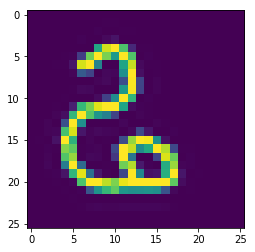

In [31]:
plt.imshow(aff_sample)
plt.show()

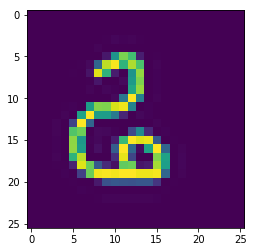

In [32]:
plt.imshow(sample)
plt.show()

## Results:

My model resulted in around 81% accuracy with a standard deviation of about 9% for each trial's accuracy. The histogram below shows the scores of the model over 1000 trials.

In [74]:
scores = np.load('scores_best.npy')
print('Mean score: ' + str(100*scores.mean()) + '%\nStdev of scores: ' + str(100*scores.std()) + '%')

Mean score: 81.535%
Stdev of scores: 9.37916707389%


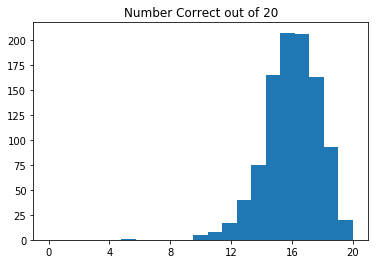

In [75]:
histo = np.histogram(scores, bins=21, range=(0,20))
plt.hist(20*scores, bins=21, range=(0,20))
plt.title("Number Correct out of 20")
plt.xticks(np.arange(0,21,step=4))
plt.show()

### Possible Future Improvements:
Overall, this model achieved decent results for accuracy. However, the model could have better consistency. This could mean that there is room to significantly reduce overfitting of the network. Adding in more rotations/affine transformations of images to augment the existing data could help with this task.

I also noticed that downscaling the images may cause some "blur" that might affect the efficacy of the convolutional filters. Sending the image values to binary might create sharper edge detection. 

Regarding network architecture, I think that trying different architectures for the relational portion would be the most effective because it is critical for discerning between images. 

In addition, the model could be trained for more episodes to reduce overfitting (the Relational Network paper trained for 1 million episodes), and there is much room to experiment with different class/example distributions.